# CNN pretrained ResNet50 model 

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* Tests have shown that adding a dropout layer to the architecture, batch size of 16 as well as regularization increased the models performance. This is included in this model as well as setting model checkpoints.
* Thoughts on model checkpoints:
  * model.evaluate() in Keras uses the weights of the model at the time the method is called. So if you train a model for 20 epochs and call model.evaluate() immediately after training without making any further changes to the weights, then it will use the weights from the last, 20th epoch.
  * However, if you use a ModelCheckpoint with save_best_only=True during training, then the model's weights will only be saved if a particular metric (such as validation accuracy) improves. If you load these best weights into your model after training and then call model.evaluate(), the weights of the epoch with the best results will be used.
  * In summary, model.evaluate() always uses the current weights of the model. It is up to you to determine which weights are loaded in the model at which point in time. This is why we should use ModelCheckpoint with save_best_only=True to evaluate the *best* model.
* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images
* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and loading Data

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import math

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam as Adam_legacy
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.utils import class_weight


sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 25

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"
FILEPATH_MODELS = "../models/"

MODEL_NAME = 'Resnet50_tertiary_new_setup_huesaturation_l2_08_noDensenodrop_batch8_rotation15' # please adapt according to your changes using _ and - instead of " "

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 8 # Adapted according to findings

### Loading (augmented) metadata as test, train, validation from files

In [2]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,dx_tertiary,image_path
1496,HAM_0001837,ISIC_0033868.jpg,bkl,histo,80.0,male,trunk,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0033868.jpg
5062,HAM_0005276,aug_rkw0eQISIC_0028790.jpg,df,histo,75.0,male,back,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_rkw0eQISIC_0028790.jpg
378,HAM_0003833,ISIC_0031149.jpg,nv,histo,75.0,female,lower extremity,vienna_dias,not_skin_cancer,benign,./../data/jpgs/ISIC_0031149.jpg
5231,HAM_0004960,aug_gLRMibISIC_0027876.jpg,df,histo,65.0,female,lower extremity,rosendahl,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_gLRMibISIC_0027876.jpg
5152,HAM_0007526,aug_y6JvHqISIC_0031827.jpg,df,histo,50.0,male,lower extremity,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_y6JvHqISIC_0031827.jpg
1587,HAM_0000097,ISIC_0033103.jpg,mel,histo,65.0,male,foot,vidir_modern,skin_cancer,malignant,./../data/jpgs/ISIC_0033103.jpg
926,HAM_0006601,ISIC_0031511.jpg,bkl,consensus,80.0,male,abdomen,vidir_molemax,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0031511.jpg
4849,HAM_0007051,aug_AwL9vBISIC_0031002.jpg,df,histo,65.0,male,upper extremity,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_AwL9vBISIC_0031002.jpg
512,HAM_0002932,ISIC_0027841.jpg,nv,follow_up,60.0,male,lower extremity,vidir_molemax,not_skin_cancer,benign,./../data/jpgs/ISIC_0027841.jpg
1046,HAM_0005126,ISIC_0028822.jpg,bkl,confocal,65.0,male,neck,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0028822.jpg


## Setting up the image data generator for training and validation

#### Function for custom preprocessing of the images

In [3]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

#### Data Image generator for Train and Validation

In [4]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    zoom_range=0.2,              # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    rotation_range=15,           # Randomly rotate images by up to 30 degrees
    shear_range=0.2,             # Shear intensity (shear angle in radians)
    fill_mode='nearest'          # Strategy for filling in newly created pixels after transformations
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    #save_to_dir=FILEPATH_OUTPUT,
    #save_prefix="test_gen_",
    #save_format="jpg",
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


### Control: Show some images from the train data set after preprocessing

In [5]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [6]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 0.99215686 float32


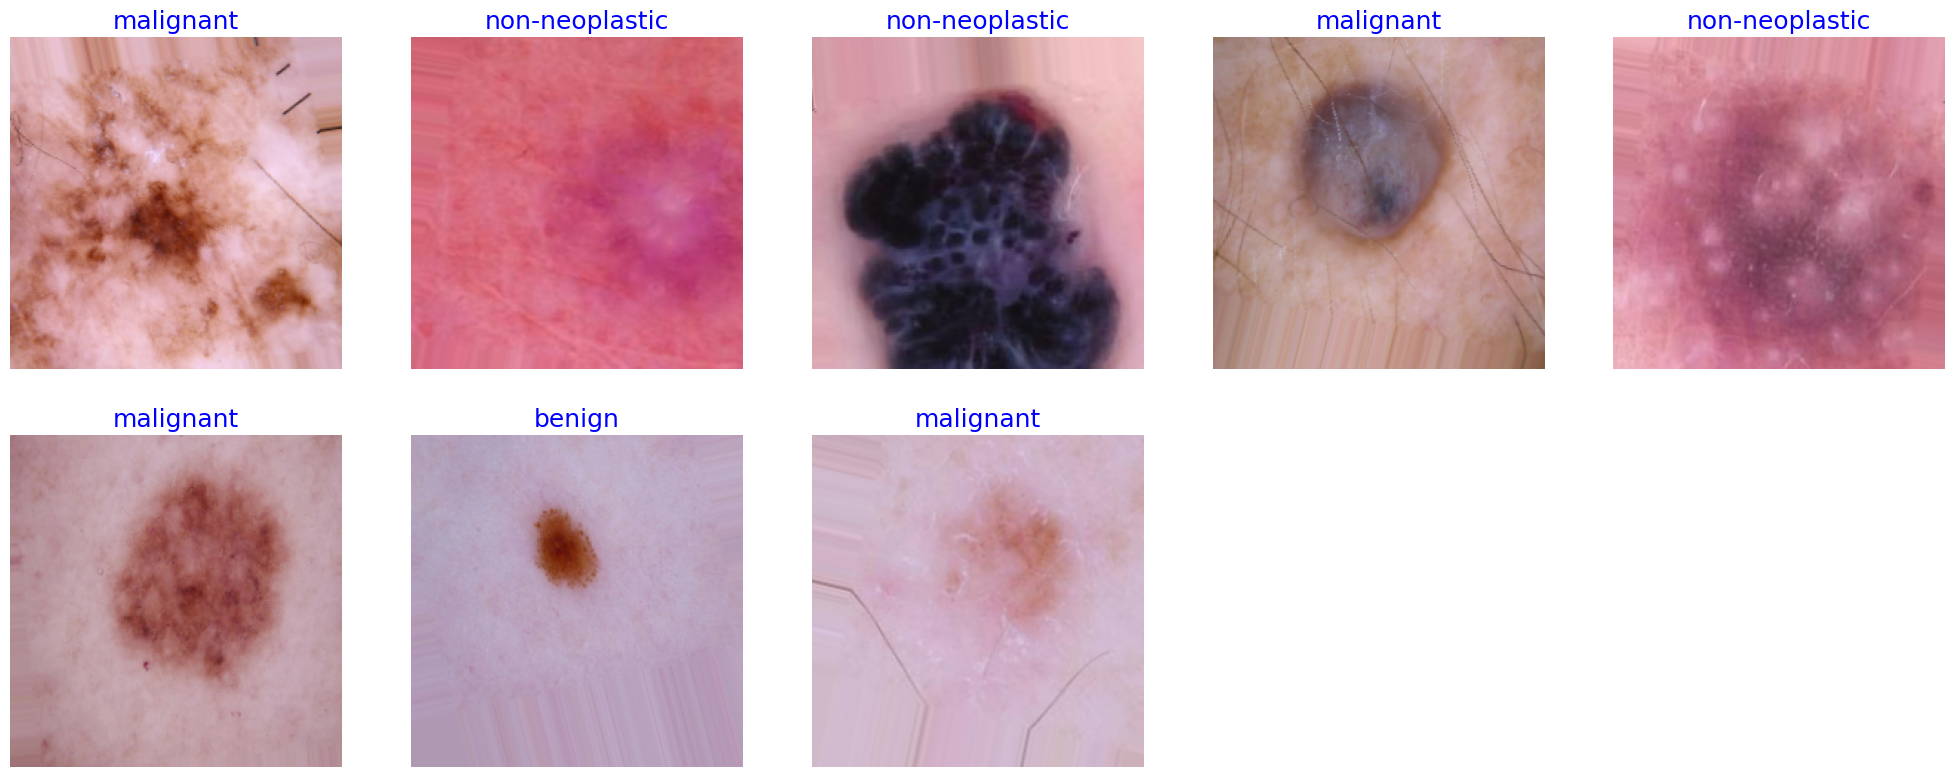

In [7]:
show_image_samples(train_data_generator)

## ResNet50 Setup


### Model architecture

In [8]:
# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu',
           kernel_regularizer=l2(0.8)
           )(x)
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
  
#x = Dense(128, activation='relu', kernel_regularizer=l2(0.1))(x)    

#x = Dropout(0.5)(x)                                                 

x= Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.8))(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x, name=MODEL_NAME)

model.compile(
    optimizer=Adam_legacy(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy', mh.f1_score])

# Print model summary
#model.summary()

### Callback functions

#### Learning rate scheduler for model compilation

In [9]:
# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 3  # Number of epochs after which learning rate will drop

    # Calculate the learning rate for the current epoch
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

#### Early stopping

In [10]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=15,         # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

#### Model checkpoint

In [11]:
timestamp = datetime.now()

best_weights_checkpoint = ModelCheckpoint(
    filepath = f'{FILEPATH_MODELS}model_best-epoch_{timestamp}.h5', 
    save_best_only=True, 
    save_weights_only=False,
    monitor='val_accuracy', 
    mode='max', 
    verbose=1
)

### Class weights 

In [12]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.335111111111111, 1: 0.7776791000592066, 2: 0.7776791000592066}

## Model Training

In [13]:
# Train the model
history = model.fit(
    train_data_generator,       # Training data generator
    epochs=NUM_EPOCHS,          # Number of training epochs
    verbose=1,                  # Verbosity level during training (0, 1, or 2)
    batch_size=BATCH_SIZE,      # Batch size for training
    callbacks=[
        lr_scheduler, 
        early_stopping,
        best_weights_checkpoint],
    validation_split=0.0,       # Fraction of the training data to use as validation data (0.0 means no split)
    validation_data=validation_generator,  # Validation data generator
    shuffle=True,               # Shuffle the training data before each epoch
    sample_weight=None,         # Optional sample weights for training data
    class_weight=class_weights,  # Optional class weights for loss calculation
    initial_epoch=0,            # Initial training epoch (useful for resuming training)
    steps_per_epoch=None,       # Number of steps per epoch (default is len(x_train) // batch_size)
    validation_steps=None,      # Number of steps for validation (default is len(x_val) // batch_size)
    validation_batch_size=None,  # Batch size for validation (default is batch_size)
    validation_freq=1,          # Frequency to validate the model on the validation set
    max_queue_size=10,          # Maximum size of the generator queue
    workers=-1,                 # Maximum number of processes to generate data in parallel (-1 means all CPUs)
    use_multiprocessing=False   # Use multiprocessing for data generation (True or False)
)

Epoch 1/25
657/657 [==============================] - ETA: 0s - loss: 15.5070 - accuracy: 0.6475 - f1_score: 0.6079
Epoch 1: val_accuracy improved from -inf to 0.48352, saving model to ../models/model_best-epoch_2023-10-14 00:14:26.151926.h5


/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


657/657 [==============================] - 958s 1s/step - loss: 15.5070 - accuracy: 0.6475 - f1_score: 0.6079 - val_loss: 3.7111 - val_accuracy: 0.4835 - val_f1_score: 0.3739 - lr: 1.0000e-04
Epoch 2/25
657/657 [==============================] - ETA: 0s - loss: 2.5332 - accuracy: 0.7128 - f1_score: 0.6864
Epoch 2: val_accuracy improved from 0.48352 to 0.77622, saving model to ../models/model_best-epoch_2023-10-14 00:14:26.151926.h5
657/657 [==============================] - 959s 1s/step - loss: 2.5332 - accuracy: 0.7128 - f1_score: 0.6864 - val_loss: 1.9262 - val_accuracy: 0.7762 - val_f1_score: 0.7574 - lr: 1.0000e-04
Epoch 3/25
657/657 [==============================] - ETA: 0s - loss: 1.6281 - accuracy: 0.7640 - f1_score: 0.7463
Epoch 3: val_accuracy improved from 0.77622 to 0.78322, saving model to ../models/model_best-epoch_2023-10-14 00:14:26.151926.h5
657/657 [==============================] - 959s 1s/step - loss: 1.6281 - accuracy: 0.7640 - f1_score: 0.7463 - val_loss: 1.5009 -

## Plotting accuracy and loss of train and validation set

#### Plotting Accuracy  of train and validation set

(0.0, 1.0)

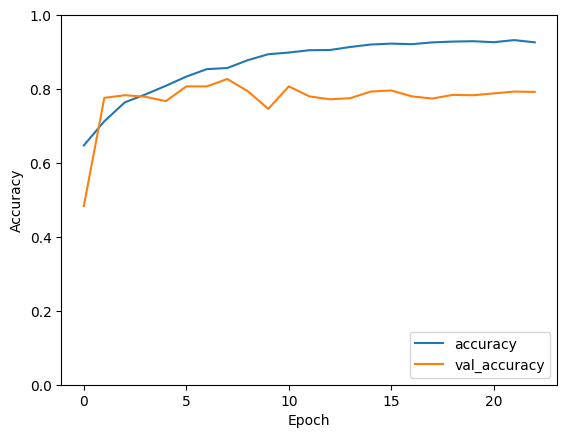

In [14]:
# plotting accuracy of train and validation
mh.model_plot_accuracy(history)
plt.ylim(0,1)

#### F1 Score of train and validation set

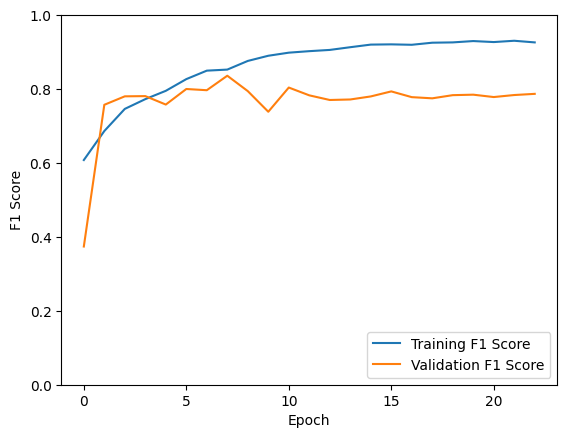

In [15]:
# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

#### Plotting Loss of train and validation set

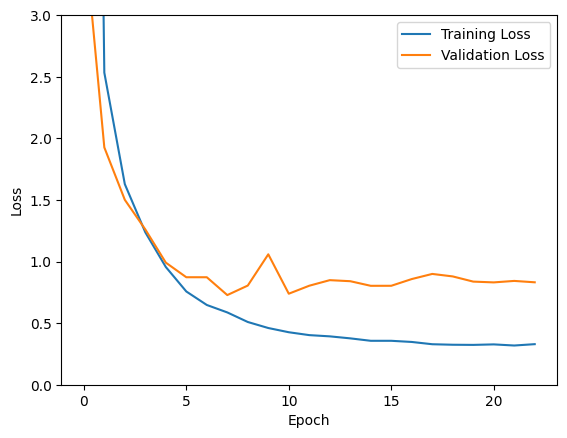

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


## Evaluating the model on the test set

 > Evaluating model Resnet50_tertiary_new_setup_huesaturation_l2_08_noDensenodrop_batch8_rotation15:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 42s 1s/step
 > Model predictions obtained.
 > Macro AUC: 0.9187180857087919
 > Micro AUC: 0.945050766730013


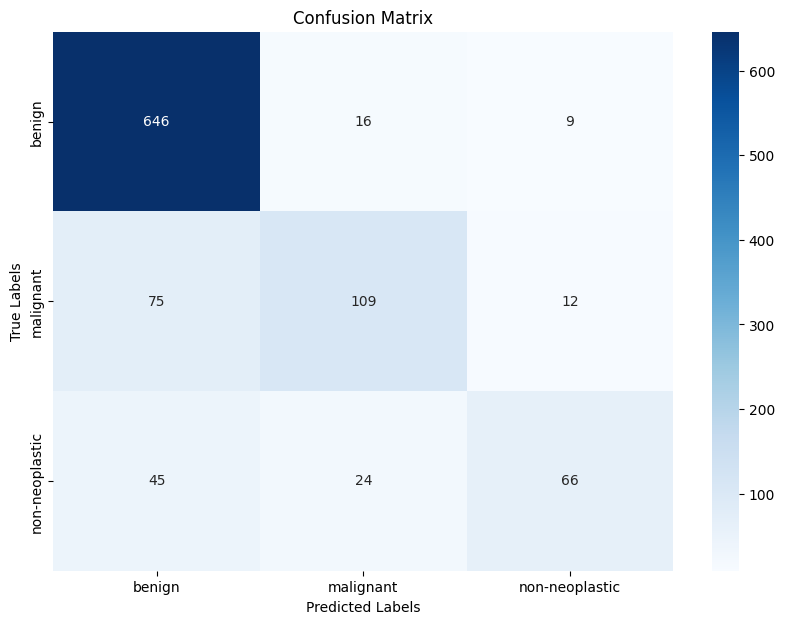



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       671
           1       0.73      0.56      0.63       196
           2       0.76      0.49      0.59       135

    accuracy                           0.82      1002
   macro avg       0.78      0.67      0.71      1002
weighted avg       0.81      0.82      0.81      1002

 > Evaluating model on test set...
32/32 [==============================] - 42s 1s/step - loss: 0.7908 - accuracy: 0.8194 - f1_score: 0.8248
loss: 0.790815532207489
accuracy: 0.8193612694740295
f1_score: 0.8247557282447815
 > Done.


([{'loss': 0.790815532207489},
  {'accuracy': 0.8193612694740295},
  {'f1_score': 0.8247557282447815}],
 array([[646,  16,   9],
        [ 75, 109,  12],
        [ 45,  24,  66]]),
 (0.945050766730013, 0.9187180857087919))

In [17]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [18]:
timestamp = datetime.now()
model_path = f"{FILEPATH_MODELS}model_last-epoch_{timestamp}.h5"
model.save(model_path)

/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Optional: Continue training 

In [19]:
# Continue training for another 10 epochs
additional_epochs = 10
continue_training = False

if continue_training:
    history_continued = model.fit(
        train_data_generator,
        steps_per_epoch=None,
        epochs=NUM_EPOCHS + additional_epochs,
        initial_epoch=NUM_EPOCHS,  # start from the epoch after your last training session
        validation_data=validation_generator)


In [20]:
if continue_training:
    mh.model_plot_accuracy(history_continued)

In [21]:
if continue_training:
    mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

In [22]:
if continue_training:
    timestamp = datetime.now()
    model_path = f"../models/model_last-epoch_{timestamp}.h5.h5"
    model.save(model_path)